In [1]:
'''
    Generate Masks for each image under the directory. Save segments under a folder which has the same 
    name as the image name, and create an xlsx file with the same name, the first column of the xlsx file
    is the index of each segments.
    
    Author: ZJ Gao
    Date: 9/26/2023
'''

'\n    Generate Masks for each image under the directory. Save segments under a folder which has the same \n    name as the image name, and create an xlsx file with the same name, the first column of the xlsx file\n    is the index of each segments.\n    \n    Author: ZJ Gao\n    Date: 9/26/2023\n'

In [2]:
# !pip install mplcursors

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torchvision
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import matplotlib.colors as mcolors
import json
import os
import pandas as pd

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.3.1
Torchvision version: 0.18.1


# Generate Grain Mask Using SegEvyThg

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import time
from datetime import datetime

class SegmentationProcessor:
    def __init__(self, model_type="vit_b", checkpoint_path="sam_vit_b_01ec64.pth"):
        """
        Initialize the segmentation model.
        
        Parameters:
        - model_type: The model type to use ("vit_b", "vit_l", "default").
        - checkpoint_path: Path to the model checkpoint file.
        """
        self.sam_model = sam_model_registry[model_type](checkpoint=checkpoint_path)
        self.mask_generator = SamAutomaticMaskGenerator(self.sam_model)
    
    def generate_masks(self, image_path):
        """
        Generate segmentation masks for the given image.
        
        Parameters:
        - image_path: Path to the input image.
        
        Returns:
        - List of masks generated for the image.
        """
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return self.mask_generator.generate(image)
    
    def extract_segmented_part(self, image, mask):
        """
        Extract the segmented part of an image using a binary mask.
        
        Parameters:
        - image: The original image.
        - mask: Binary segmentation mask.
        
        Returns:
        - Segmented part of the image with background set to black.
        """
        if len(image.shape) == 3:
            mask = np.expand_dims(mask, axis=-1)
            mask = np.repeat(mask, image.shape[2], axis=-1)
        return np.where(mask, image, 0)
    
    def save_indexes_and_masks(self, indexes, directory, masks, image_name):
        """
        Save indexes to an Excel file and masks to a JSON file.
        
        Parameters:
        - indexes: List of mask indexes.
        - directory: Directory to save files.
        - masks: List of masks.
        - image_name: Name of the image file (without extension).
        """
        df = pd.DataFrame(indexes, columns=["Index"])
        df.to_excel(os.path.join(directory, f"{image_name}_indexes.xlsx"), index=False)
        
        for mask in masks:
            if isinstance(mask['segmentation'], np.ndarray):
                mask['segmentation'] = mask['segmentation'].tolist()
        
        with open(os.path.join(directory, f"{image_name}.json"), 'w') as file:
            json.dump(masks, file)
    
    def save_segmented_parts(self, image_path, masks):
        """
        Save segmented parts of the image based on the provided masks as PNG files.
        
        Parameters:
        - image_path: Path to the original image.
        - masks: List of segmentation masks.
        """
        image = plt.imread(image_path)
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        sub_folder = os.path.join("Seg_Images", image_name)
        
        os.makedirs(sub_folder, exist_ok=True)
        
        indexes = []
        for i, mask_data in enumerate(masks):
            segmented_part = self.extract_segmented_part(image, mask_data['segmentation'].astype(np.uint8))
            plt.imsave(os.path.join(sub_folder, f"{i}.png"), segmented_part)
            indexes.append(i)
        
        self.save_indexes_and_masks(indexes, sub_folder, masks, image_name)
    
    @staticmethod
    def is_image_file(filename):
        """
        Check if a filename corresponds to an image file.
        
        Parameters:
        - filename: Name of the file.
        
        Returns:
        - True if the file is an image, False otherwise.
        """
        return filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"))
    
    def process_directory(self, input_directory="To_be_Seg"):
        """
        Process all images in a directory, generating masks and saving segmented parts.
        
        Parameters:
        - input_directory: Directory containing images to be processed.
        """
        start_time = time.time()
        
        for filename in os.listdir(input_directory):
            if self.is_image_file(filename):
                image_path = os.path.join(input_directory, filename)
                masks = self.generate_masks(image_path)
                self.save_segmented_parts(image_path, masks)
                
                elapsed_time = (time.time() - start_time) / 60
                print(f"Finished processing {filename}. Elapsed time: {elapsed_time:.2f} minutes")

Go to `To_be_Seg` folder and put the image there

Caution! Once you click the script below, SAM will start to work and segment whatever you put in the folder.

In [3]:
# Usage example:
processor = SegmentationProcessor(model_type="vit_b", checkpoint_path="sam_vit_b_01ec64.pth")
processor.process_directory("To_be_Seg")

Finished processing 4536 Elemental Map.tiff. Elapsed time: 1.48 minutes


# Visualize Segments

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

def load_masks_from_json(json_path):
    """
    Load masks from a JSON file.

    Parameters:
    - json_path (str): The path to the JSON file.

    Returns:
    - masks: The loaded masks.
    """
    with open(json_path, 'r', encoding='utf-8') as file:
        masks = json.load(file)
    
    # Convert segmentation lists back to numpy arrays
    for mask in masks:
        mask['segmentation'] = np.array(mask['segmentation'])
    
    return masks

def display_binary_mask_and_overylay(image, masks, filter_list=None, image_2=None, overlay_color=(0, 255, 0), alpha=0.3):
    """
    Display 1) original image; 2) Binary mask; 3) original image with layered with the mask, mask's color is chosable
    Parameters:
    image (numpy array): The image to display.
    masks (list): The list of masks (dictionaries with 'segmentation' key).
    filter_list (list): List of indices to exclude from display (optional).
    image_2 (numpy array): The second image to overlay masks on (optional).
    overlay_color (tuple): The RGB color for the overlay (default is green).
    alpha (float): The transparency level of the overlay (default is 0.3).

    Returns:
    numpy array: The combined mask.
    """
    # Generate idx_list by enumerating each mask
    idx_list = list(range(len(masks)))

    # If filter_list is provided, filter out the indices that are in the filter_list
    if filter_list is not None:
        idx_list = [idx for idx in idx_list if idx not in filter_list]

    # Initialize a mask of zeros with the same size as the original image
    combined_mask = np.zeros_like(image[:,:,0], dtype=np.uint8)

    for idx, segmentation_entry in enumerate(masks):
        if idx in idx_list:  # Only consider masks in idx_list
            segmentation_mask = np.array(segmentation_entry['segmentation']).astype(np.uint8)
            # Combine the mask
            combined_mask = np.logical_or(combined_mask, segmentation_mask)

    # Convert combined_mask back to uint8 for visualization
    combined_mask = combined_mask.astype(np.uint8)

    # Create overlayed images
    overlayed_image = image.copy()
    
    if image_2 is not None:
        overlayed_image_2 = image_2.copy()
    
    # Create an overlay of the same size as the original image with the specified color
    color_overlay = np.zeros_like(image)
    color_overlay[combined_mask == 1] = overlay_color

    # Compute the alpha-blended images only in the regions specified by the mask
    overlayed_image[combined_mask == 1] = (color_overlay[combined_mask == 1] * alpha + 
                                           image[combined_mask == 1] * (1 - alpha)).astype(np.uint8)
    
    if image_2 is not None:
        overlayed_image_2[combined_mask == 1] = (color_overlay[combined_mask == 1] * alpha + 
                                                 image_2[combined_mask == 1] * (1 - alpha)).astype(np.uint8)

    plt.figure(figsize=(30,20))

    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Display the combined mask
    plt.subplot(2, 3, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('Combined Mask')
    plt.axis('off')

    # Display the overlayed images
    plt.subplot(2, 3, 3)
    plt.imshow(overlayed_image)
    plt.title('Overlayed on Original Image')
    plt.axis('off')

    if image_2 is not None:
        plt.subplot(2, 3, 4)
        plt.imshow(overlayed_image_2)
        plt.title('Overlayed on Image 2')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
# image = cv2.imread(image_path)
# if image is None:
#     print("Error: Image not loaded. Please check the path and file format.")


Error: Image not loaded. Please check the path and file format.


In [8]:
import os

def get_paths():
    # Get the image name from To_be_seg folder
    to_be_seg_path = r'To_be_seg'
    
    # List all files in the directory and filter out hidden files
    files = [f for f in os.listdir(to_be_seg_path) 
             if not f.startswith('.') and os.path.isfile(os.path.join(to_be_seg_path, f))]
    
    if not files:
        raise Exception("No valid image files found in To_be_seg folder")
    
    # Get the first file name and its name without extension
    image_filename = files[0]
    image_name = os.path.splitext(image_filename)[0]
    
    # Construct both paths
    image_path = os.path.join(to_be_seg_path, image_filename)
    json_path = os.path.join('Seg_Images', image_name, f'{image_name}.json')
    
    return image_path, json_path

# Usage
try:
    image_path, json_path = get_paths()
    print(f"Image path: {image_path}")
    print(f"JSON path: {json_path}")
except Exception as e:
    print(f"Error: {str(e)}")

Image path: To_be_seg/4536 Elemental Map.tiff
JSON path: Seg_Images/4536 Elemental Map/4536 Elemental Map.json


In [21]:
import numpy as np
import json

def analyze_masks(masks):
    """
    Analyze both confidence scores and areas from segmentation masks
    """
    # Extract values
    confidence_scores = [mask['predicted_iou'] for mask in masks]
    areas = [mask['area'] for mask in masks]
    
    # Convert to numpy arrays for calculations
    confidence_scores = np.array(confidence_scores)
    areas = np.array(areas)
    
    # Calculate statistics for confidence
    confidence_stats = {
        'total_segments': len(confidence_scores),
        'mean_confidence': np.mean(confidence_scores),
        'median_confidence': np.median(confidence_scores),
        'std_confidence': np.std(confidence_scores),
        'min_confidence': np.min(confidence_scores),
        'max_confidence': np.max(confidence_scores),
    }
    
    # Calculate statistics for areas
    area_stats = {
        'mean_area': np.mean(areas),
        'median_area': np.median(areas),
        'std_area': np.std(areas),
        'min_area': np.min(areas),
        'max_area': np.max(areas),
        'total_area': np.sum(areas)
    }
    
    return confidence_stats, area_stats

def print_mask_stats(confidence_stats, area_stats):
    print("\nSegmentation Analysis Summary:")
    print("\nConfidence Statistics:")
    print(f"Total segments: {confidence_stats['total_segments']}")
    print(f"Mean confidence: {confidence_stats['mean_confidence']:.4f}")
    print(f"Median confidence: {confidence_stats['median_confidence']:.4f}")
    print(f"Std deviation: {confidence_stats['std_confidence']:.4f}")
    print(f"Range: [{confidence_stats['min_confidence']:.4f}, {confidence_stats['max_confidence']:.4f}]")
    
    print("\nArea Statistics:")
    print(f"Total area: {area_stats['total_area']}")
    print(f"Mean area: {area_stats['mean_area']:.2f}")
    print(f"Median area: {area_stats['median_area']:.2f}")
    print(f"Std deviation: {area_stats['std_area']:.2f}")
    print(f"Range: [{area_stats['min_area']}, {area_stats['max_area']}]")

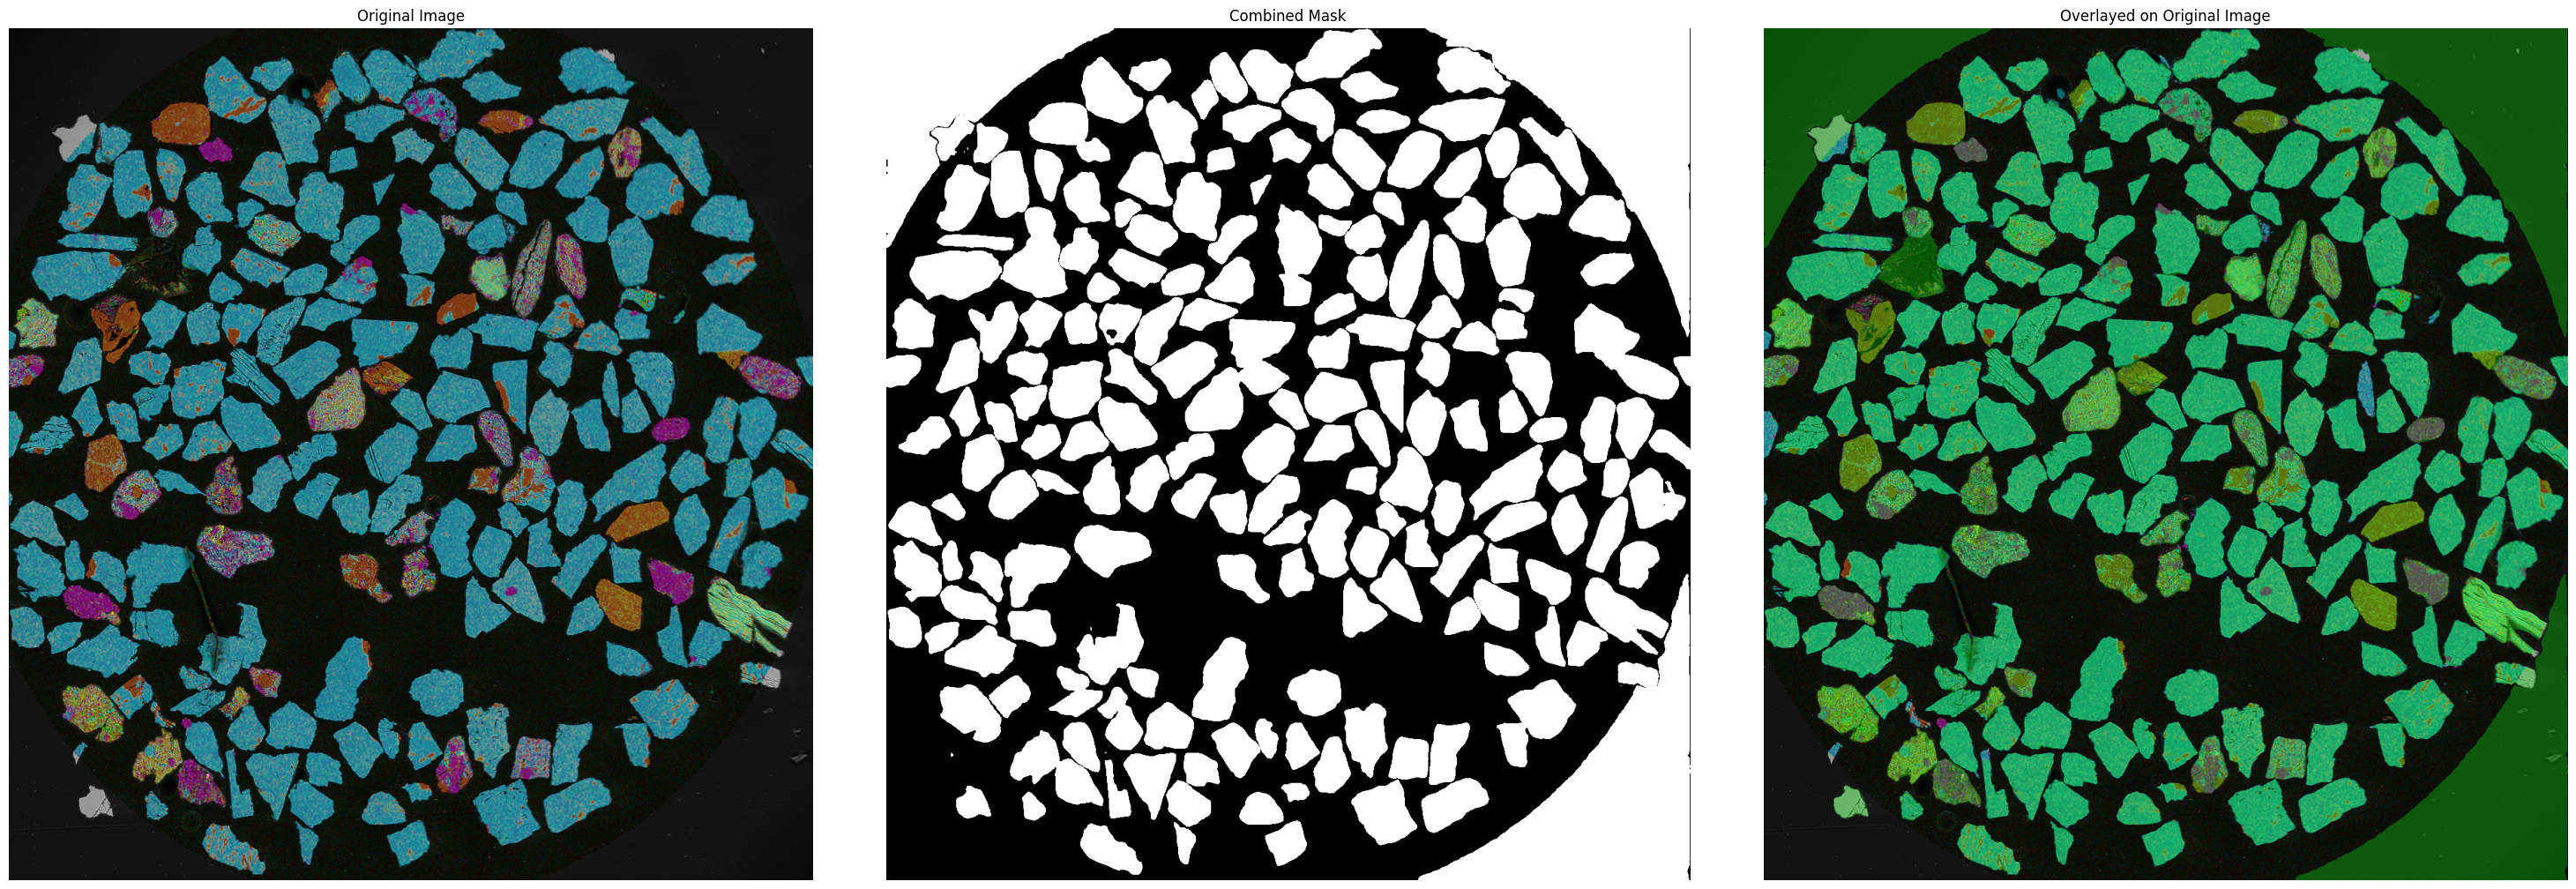

In [29]:
# Example usage
# USU-4543
# json_path = r'Seg_Images\4543 Elemental Map_aligned\4543 Elemental Map_aligned.json'
# image_path = r'Aligned\4543 Elemental Map\4543 Elemental Map_aligned.png'

# USU-4162A
# json_path = r'Seg_Images\USU-4162A 250-355 Elemental Map_aligned\USU-4162A 250-355 Elemental Map_aligned.json'
# image_path = r'Aligned\USU-4162A 250-355 Elemental Map\USU-4162A 250-355 Elemental Map_aligned.png'

# USU-4169B-GS-150-250
# json_path = r'Seg_Images\USU-4169B 150-250 Elemental Map_aligned\USU-4169B 150-250 Elemental Map_aligned.json'
# image_path = r'Aligned\USU-4169B 150-250 Elemental Map\USU-4169B 150-250 Elemental Map_aligned.png'

# USU-4169B-GS-250-355
# json_path = r'Seg_Images\USU-4183B 150-250 Elemental Map\USU-4183B 150-250 Elemental Map.json'
# image_path = r'Aligned\USU-4183B 150-250\USU-4183B 150-250 Elemental Map.jpeg'

# Directly read from To_be_seg

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks = load_masks_from_json(json_path)


display_binary_mask_and_overylay(image, masks, filter_list=[72], image_2=None, overlay_color=(0, 255, 0), alpha=0.3)

In [23]:
analyze_masks(masks)

({'total_segments': 229,
  'mean_confidence': 0.9782619260284058,
  'median_confidence': 0.9897054433822632,
  'std_confidence': 0.03334095763810781,
  'min_confidence': 0.8816370964050293,
  'max_confidence': 1.0256062746047974},
 {'mean_area': 9998.768558951964,
  'median_area': 3000.0,
  'std_area': 82166.01205645096,
  'min_area': 261,
  'max_area': 1242271,
  'total_area': 2289718})

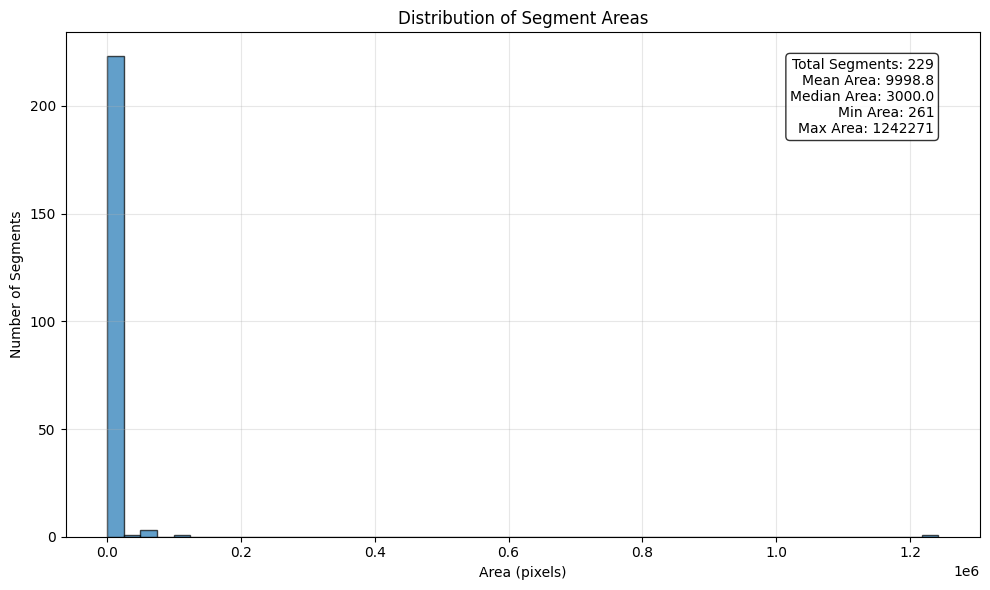

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_areas(masks):
    """
    Create a histogram visualization of segment areas
    """
    # Extract areas
    areas = [mask['area'] for mask in masks]
    areas = np.array(areas)
    
    # Create the figure
    plt.figure(figsize=(10, 6))
    
    # Create histogram
    plt.hist(areas, bins=50, edgecolor='black', alpha=0.7)
    
    # Customize the plot
    plt.title('Distribution of Segment Areas', fontsize=12)
    plt.xlabel('Area (pixels)', fontsize=10)
    plt.ylabel('Number of Segments', fontsize=10)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Add some statistics as text
    stats_text = f'Total Segments: {len(areas)}\n'
    stats_text += f'Mean Area: {np.mean(areas):.1f}\n'
    stats_text += f'Median Area: {np.median(areas):.1f}\n'
    stats_text += f'Min Area: {np.min(areas)}\n'
    stats_text += f'Max Area: {np.max(areas)}'
    
    # Position the text box in figure coords
    plt.text(0.95, 0.95, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Adjust layout to prevent text cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()


visualize_areas(masks)

In [27]:
def find_large_segments(masks, area_threshold):
    """
    Find indexes of segments with areas larger than the threshold
    
    Parameters:
    - masks: list of dictionaries containing segment information
    - area_threshold: minimum area threshold
    
    Returns:
    - list of indexes where segment area > threshold
    """
    # Find indexes where area is greater than threshold
    large_segment_indexes = [i for i, mask in enumerate(masks) if mask['area'] > area_threshold]
    
    return large_segment_indexes

# Usage example:
# area_threshold = 2000
# large_segments = find_large_segments(masks, area_threshold)
# print(f"Found {len(large_segments)} segments with area > {area_threshold}")
# print(f"Indexes: {large_segments}")

In [33]:
find_large_segments(masks, 20000)

[72, 156, 161, 169, 183, 205]

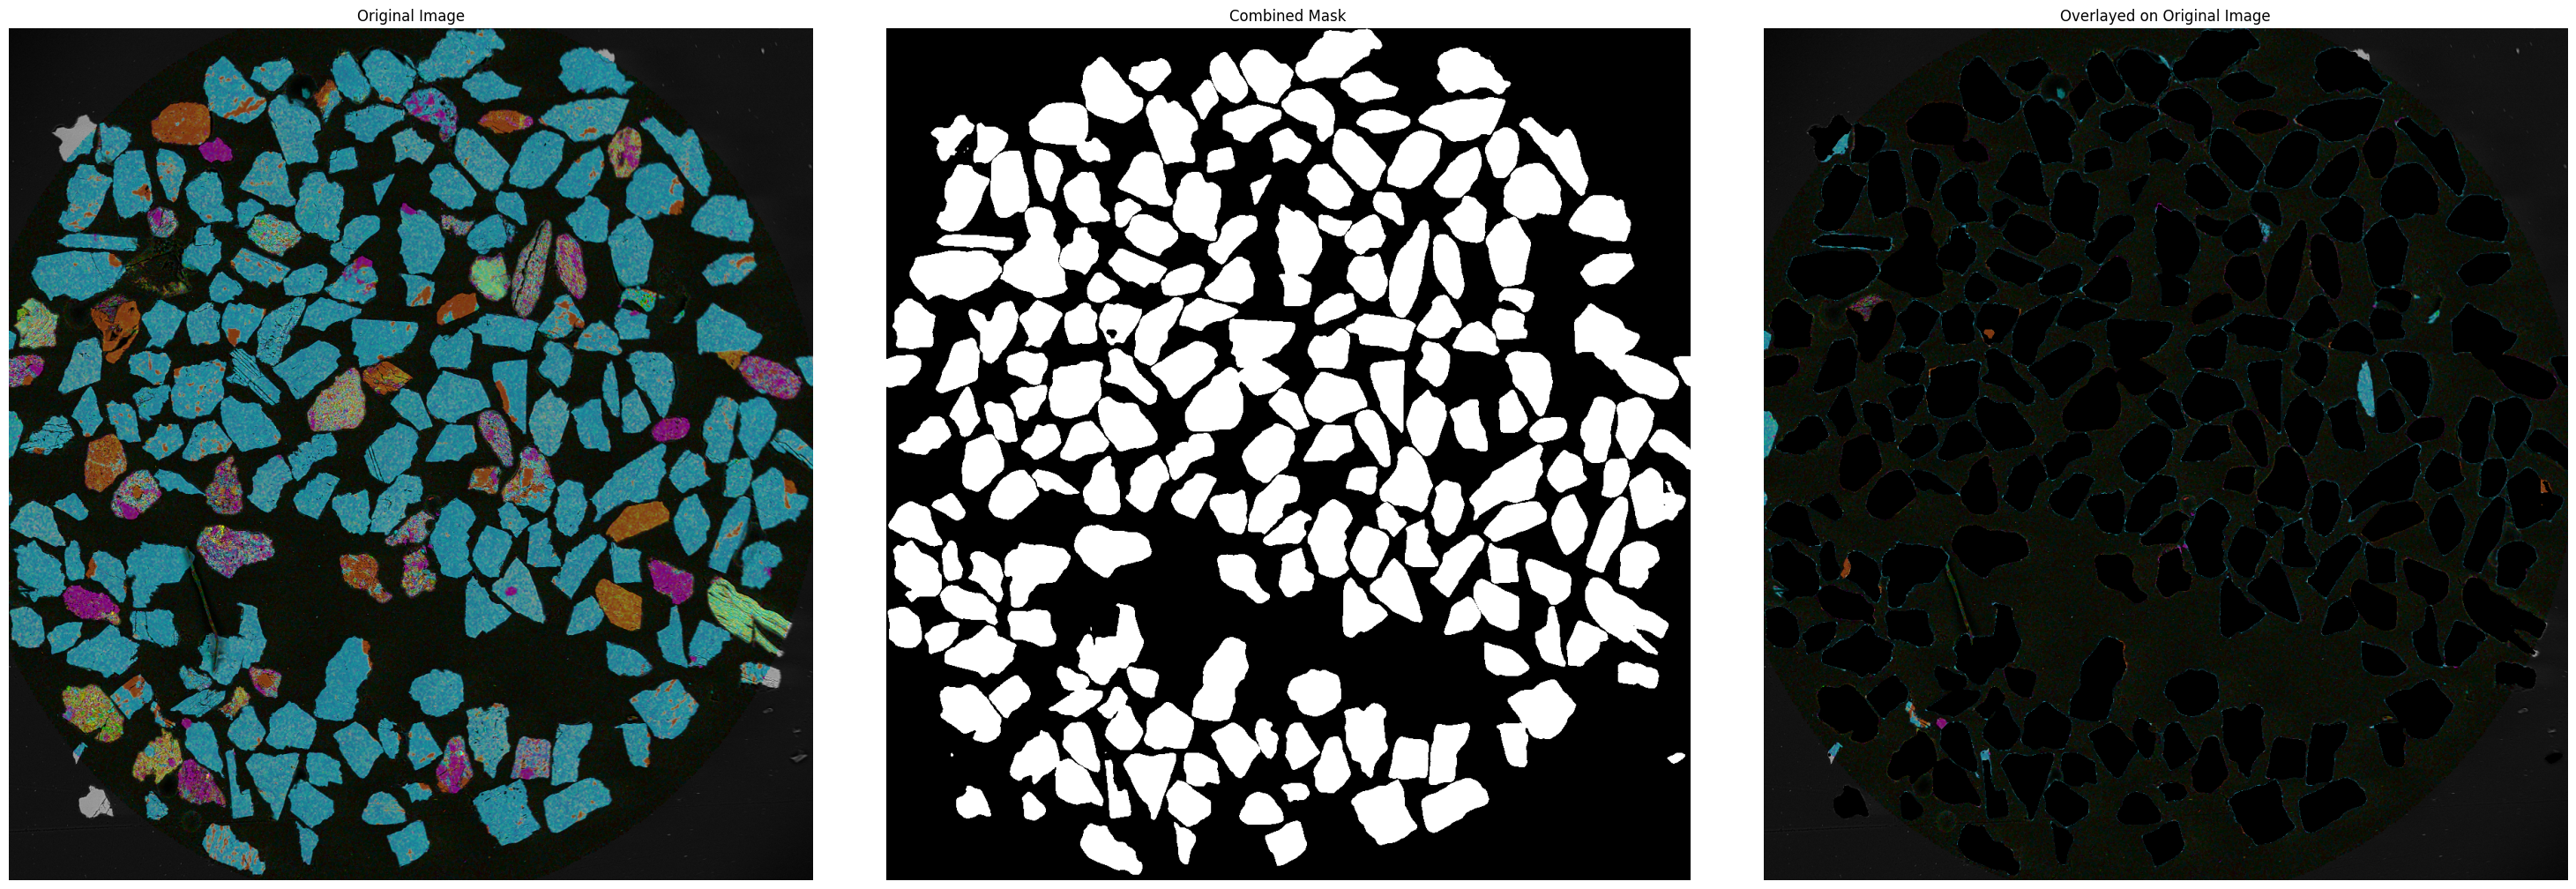

In [36]:
combined_mask = display_binary_mask_and_overylay(image, masks, filter_list=[72, 156, 161, 169, 183, 205],overlay_color=(0,0,0), alpha=1)

# Display grains with their mask indexes

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass

def display_label_on_image(image, masks, filter_list=None):
    idx_list = list(range(len(masks)))
    
    # If filter_list is provided, filter out the indices that are in the filter_list
    if filter_list is not None:
        idx_list = [idx for idx in idx_list if idx not in filter_list]

    # Create a figure for displaying the image with labels
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')
    
    # Label each mask by its index
    for idx, segmentation_entry in enumerate(masks):
        if idx in idx_list:
            segmentation_mask = np.array(segmentation_entry['segmentation']).astype(np.uint8)
            if np.any(segmentation_mask):
                y, x = center_of_mass(segmentation_mask)
                ax.text(x, y, str(idx), color='red', fontsize=6, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

    plt.show()

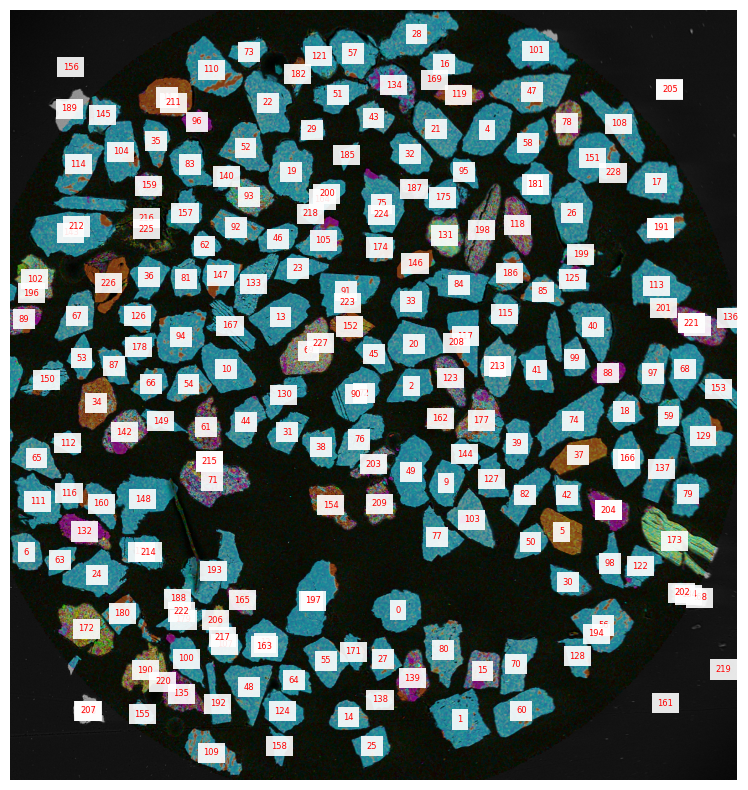

In [11]:
display_label_on_image(image, masks)